## 2 EDA

#  Contents<a id='Contents'></a>
* [1. Imports](#1._Imports)
* [2. Load The Data](#2._LoadData)
* [3. Step1: Exploring each Individual Variable](#3._Explore_individiual_variable)
    * [3.1. Measure Spread](#3.1_Measure_Spread)
    * [3.2. Distribution (Profiling)](#3.1_Distribution)
    * [3.3 Mode](#3.3_Mode)
        * [3.3.1 Categorical](#3.3.1_Categorical)
        * [3.3.2 Numerical](#3.3.2_Numerical)
    * [3.4 Time Series](#3.4_Time_Series)
* [4. Step 2: Exploring the relationship between each variable and the target](#4._Explore_relationship)
    * [4.1 Linearity Direction](#4.1_Linearity_direction)
    * [4.2 Bivariate visualizations](#4.2_Bivariate_visualization)
* [5. Step 3: Assessing interactions between variables](#5._Interaction_between_variables)
    * [5.1 Bivariate visualizations_for all combinations](#5.1_Bivariate_for_all)
    * [5.2 Correlation_matrices](#5.2_Correlation_matrices)
    * [5.3 summary statistics of variable x for different categories of y](#5.3_Compare_summary_statistic)
* [6. Step 4: Exploring data across many dimensions](#6._Explore_Data)
    * [6.1. Hypothesis Testing](#6.1_Hypothesis_test)
    * [6.2. Questions](#6.2_Questions)
* [7. Save Data](#7._Save)

## 1. Imports <a id='1._Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from pandas_profiling import ProfileReport

## 2.2 Load The Data<a id='2._LoadData'></a>

In [2]:
card_data = pd.read_csv('data/transaction_data_cleaned.csv',parse_dates=True)


In [3]:
card_data.dtypes

accountNumber                 int64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                  int64
posConditionCode              int64
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
transactionType              object
currentBalance              float64
cardPresent                    bool
expirationDateKeyInMatch       bool
isFraud                        bool
CVVMatch                       bool
containsCom                    bool
lengthOfLast4Digits           int64
creditLimitCategory           int64
dtype: object

## 3 Step1: Exploring each individual variable<a id='3._Explore_individiual_variable'></a>

### 3.1 Measure Spread<a id='3.1_Measure_Spread'></a>

Lets check the spread of continuous variable:
- transactionAmount
- availableMoney
- currentBalance


### (a) IQR using boxplot

<AxesSubplot:>

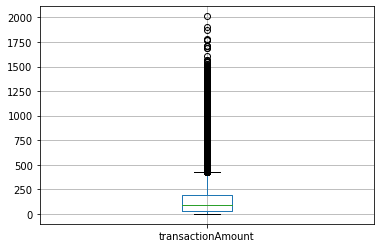

In [4]:
# Question 1: Does this box plot means there is no outlier?
# 1. transaction amount 
card_data.boxplot(column = ['transactionAmount'],return_type = 'axes')

<AxesSubplot:>

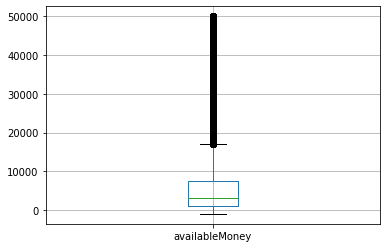

In [5]:
# 2. available money
card_data.boxplot(column = ['availableMoney'],return_type = 'axes')

<AxesSubplot:>

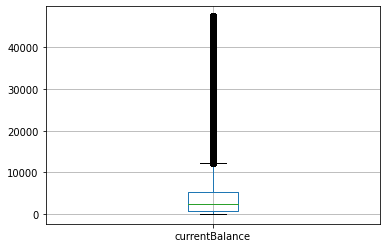

In [6]:
# 3. available money
card_data.boxplot(column = ['currentBalance'],return_type = 'axes')

### (b) Mean , Standard deviation

In [7]:
print('All data: ')
card_data[['currentBalance','availableMoney','transactionAmount']].describe()

All data: 


currentBalance  availableMoney  transactionAmount
count   727282.000000   727282.000000      727282.000000
mean      4552.563597     6275.074788         136.964097
std       6520.221249     8875.817568         147.679849
min          0.000000    -1005.630000           0.000000
25%        703.842500     1085.725000          33.650000
50%       2477.565000     3208.205000          87.930000
75%       5341.390000     7500.000000         191.520000
max      47498.810000    50000.000000        2011.540000

Lets check the fraud entries

In [8]:
print('Fraud transactions summary: ')
card_data[card_data.isFraud == True][['currentBalance','availableMoney','transactionAmount']].describe()


Fraud transactions summary: 


currentBalance  availableMoney  transactionAmount
count    11311.000000    11311.000000       11311.000000
mean      5030.909115     6178.245690         225.379355
std       7255.513001     8672.785235         189.691161
min          0.000000     -614.390000           0.000000
25%        852.200000     1088.285000          85.910000
50%       2833.980000     3142.570000         177.300000
75%       5840.900000     7662.350000         312.225000
max      47473.940000    50000.000000        1608.350000

In [9]:
print('Non-Fraud transactions summary: ')
card_data[card_data.isFraud == False][['currentBalance','availableMoney','transactionAmount']].describe()


Non-Fraud transactions summary: 


currentBalance  availableMoney  transactionAmount
count   715971.000000   715971.000000      715971.000000
mean      4545.006635     6276.604506         135.567302
std       6507.661974     8878.985294         146.492407
min          0.000000    -1005.630000           0.000000
25%        701.435000     1085.670000          33.190000
50%       2471.690000     3209.340000          86.790000
75%       5333.800000     7500.000000         189.440000
max      47498.810000    50000.000000        2011.540000

There is a big difference in the mean transaction amount of fraud vs not fraud.
We can do Hypothesis testing

mean differences in transactions amount = $ \mu_{fraud} - \mu_{notFraud} = 225.38-135.57 = 51.43 $ dollars

Lets do permutation test in Step 4 to see if this difference is due to chance or if there is a significant difference

In [10]:
# card_data['transactionAmountLog'] = card_data['transactionAmount'].map(np.log)
# card_data['transactionAmountLog'].plot(kind='bar')

# card_data['transactionAmountLog'] = np.log10(card_data['transactionAmount'])


In [11]:
# Copy the strictly positive data to posdata:
transactionAmount = card_data['transactionAmount']
posdata = transactionAmount[transactionAmount > 0]
posdata

0          44.09
1         164.57
2         122.83
4          24.56
5          20.45
           ...  
727277    128.84
727278     49.47
727279     13.02
727280      8.85
727281    169.07
Name: transactionAmount, Length: 706639, dtype: float64

In [12]:
# Find the optimal Box-Cox transformation,
# and verify that λ is positive.
# This work-around doesn't work if λ ≤ 0.

boxCoxData, lamb = stats.boxcox(posdata)
lamb

0.23601064180716655

Make a new array to hold that result, along with the limiting value of the transform of 0 (which is -1/λ):

In [13]:
normal_trans = np.empty_like(transactionAmount)
normal_trans[transactionAmount>0] = boxCoxData

In [14]:
normal_trans[transactionAmount==0] = -1/lamb

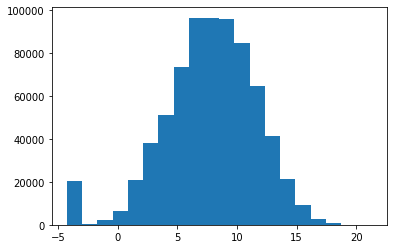

In [15]:
plt.hist(normal_trans,bins= 20)
plt.show()

In [16]:
transaction_boxcox = boxcox1p(card_data['transactionAmount'], 0.25)

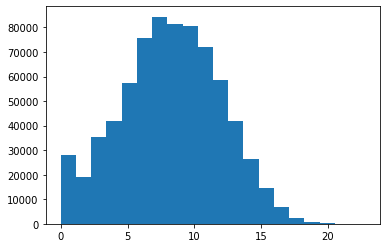

In [17]:
plt.hist(transaction_boxcox,bins= 20)
plt.show()

### 3.2 Distribution for non categorical<a id='3.2_Distribution'></a>
#### Profiling

Let's redo pandas profiling with our new column and take note of numerical distribution

In [18]:
profile = ProfileReport(card_data, title = 'Profile Report')
profile

#### Numerical<a id='Numerical'></a>

Continuous:
- currentBalance
- availableMoney 
- transactionAmount

All of them have right skewed distribution

Question 2: all continuous data are right skewed, then what do I do?


Discrete:
- lengthOfLast4Digits

86.2% have the correct 4 digits. the frequency is smaller as the number of digit decreases


### 3.3 Mode<a id='3.3_Mode'></a>
#### 3.3.1 Categorical<a id='3.3.1_Categorical'></a>

String:
- merchantname: AMC
- acqCountry: US
- transactionType: Purchase

Code: 
- posEntryMode: 5 (Integrated circuit card read)
- posConditionCode: 1 (Cardholder not present)
- merchantCategoryCode: online_retail
- creditLimitCategory: 2 ($ 2500 - $5000)

Binary:
- cardPresent: No
- expirationDateKeyInMatch: 99% False
- isFraud: 98.4% False
- CVVMatch: 99.1% True
- containsCom: 73% False


#### 3.3.2 Numerical<a id='3.3.2_Numerical'></a>

Continuous:
- currentBalance: USD 0 (4.2 percent)
- availableMoney: USD 250 (0.7 percent)
- transactionAmount: USD 0 (2.8 percent)


### 3.4 Time Series<a id='3.4_Time_Series'></a>

check if they are stationary. Observations from a non-stationary time series show seasonal effects, trends, and other structures that depend on the time index.

In [19]:
# convert to datetime object
columns_to_change = ['transactionDateTime','currentExpDate','accountOpenDate','dateOfLastAddressChange']
for column in columns_to_change:
    card_data.loc[:,column] = pd.to_datetime(card_data[column].copy())

In [20]:
card_data.dtypes

accountNumber                        int64
availableMoney                     float64
transactionDateTime         datetime64[ns]
transactionAmount                  float64
merchantName                        object
acqCountry                          object
merchantCountryCode                 object
posEntryMode                         int64
posConditionCode                     int64
merchantCategoryCode                object
currentExpDate              datetime64[ns]
accountOpenDate             datetime64[ns]
dateOfLastAddressChange     datetime64[ns]
transactionType                     object
currentBalance                     float64
cardPresent                           bool
expirationDateKeyInMatch              bool
isFraud                               bool
CVVMatch                              bool
containsCom                           bool
lengthOfLast4Digits                  int64
creditLimitCategory                  int64
dtype: object

In [21]:
# Question 3
# extract time and date for transaction time
card_data['transactionTime'],card_data['transactionDate'] = card_data['transactionDateTime'].apply(lambda x:x.time()), card_data['transactionDateTime'].apply(lambda x:x.date())
# convert datatypes
card_data.loc[:,'transactionDate'] = pd.to_datetime(card_data['transactionDate'].copy())
card_data['transactionTime'] = pd.to_datetime(card_data['transactionTime'],format= '%H:%M:%S' ).dt.hour


<AxesSubplot:>

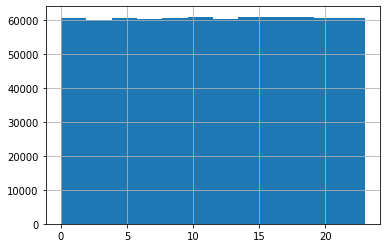

In [22]:
# Question 4: 
# I wanted to see the frequency of transaction in hours. but with histogram, the bins changes shape . Wyhich one is bestI wanted to see the frequency of transaction in hours. but with histogram, the bins changes shape . Wyhich one is bestI wanted to see the frequency of transaction in hours.
# but with histogram, the bins changes shape . Which one is best

# histogram for 24 hour period.
# bin range every 2 hours
card_data['transactionTime'].hist(bins = 12)

time transaction is stationary. lets check months

(array([56417., 56441., 57220., 59968., 58891., 59929., 62138., 61083.,
        61749., 64321., 63072., 66053.]),
 array([16801.        , 16831.33333333, 16861.66666667, 16892.        ,
        16922.33333333, 16952.66666667, 16983.        , 17013.33333333,
        17043.66666667, 17074.        , 17104.33333333, 17134.66666667,
        17165.        ]),
 <BarContainer object of 12 artists>)

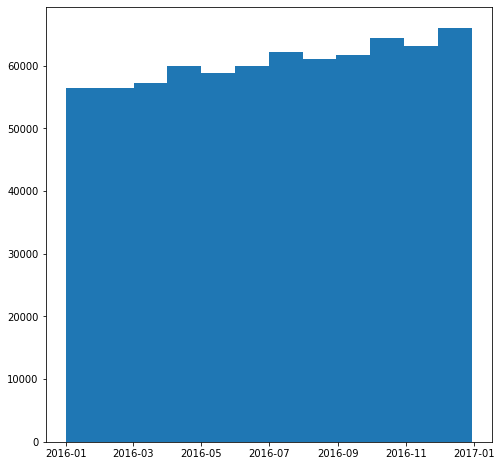

In [23]:
plt.figure(figsize=(8,8))
plt.hist(card_data['transactionDate'],bins = 12)

In [24]:
card_data['transactionYear'] = card_data['transactionDate'].dt.year
card_data['transactionMonth'] = card_data['transactionDate'].dt.month

Question 5: Help correct this

<AxesSubplot:xlabel='transactionMonth,transactionYear'>

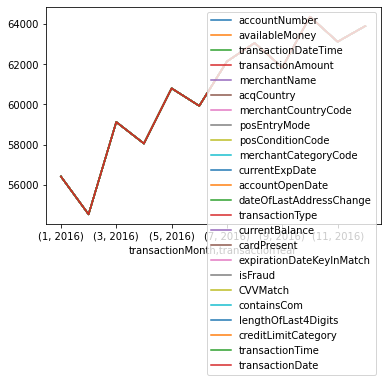

In [25]:
card_data.groupby(by=['transactionMonth', 'transactionYear']).count().plot()

There is an increasing trend in the number of transactions

## 4. Step 2: Exploring relationship with target<a id='4._Explore_relationship'></a>

### 4.1 Linearity Direction<a id='4.1_Linearity Direction'></a>

Question 6: Can I determine linearity direction when y is binary?

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


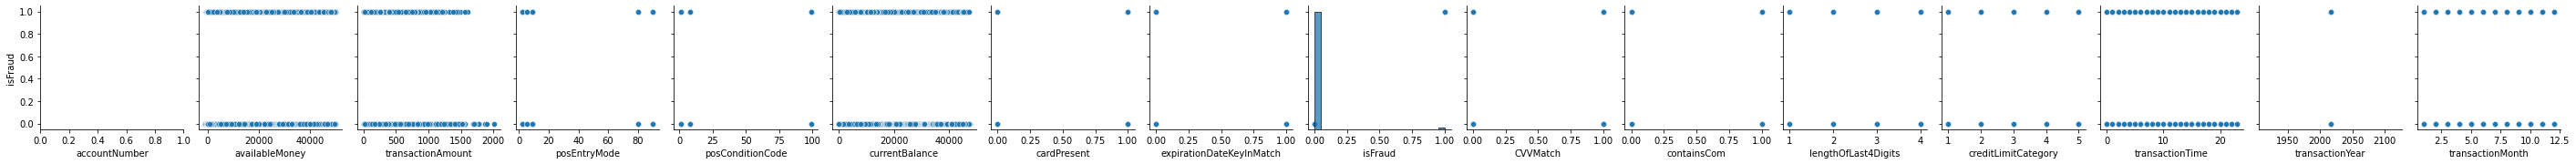

In [26]:
sns.pairplot(data=card_data, y_vars=['isFraud'])
plt.show()

### 4.2 Bivariate Visualization <a id='4.2_Bivariate_visualization'></a>
Calculate correlation

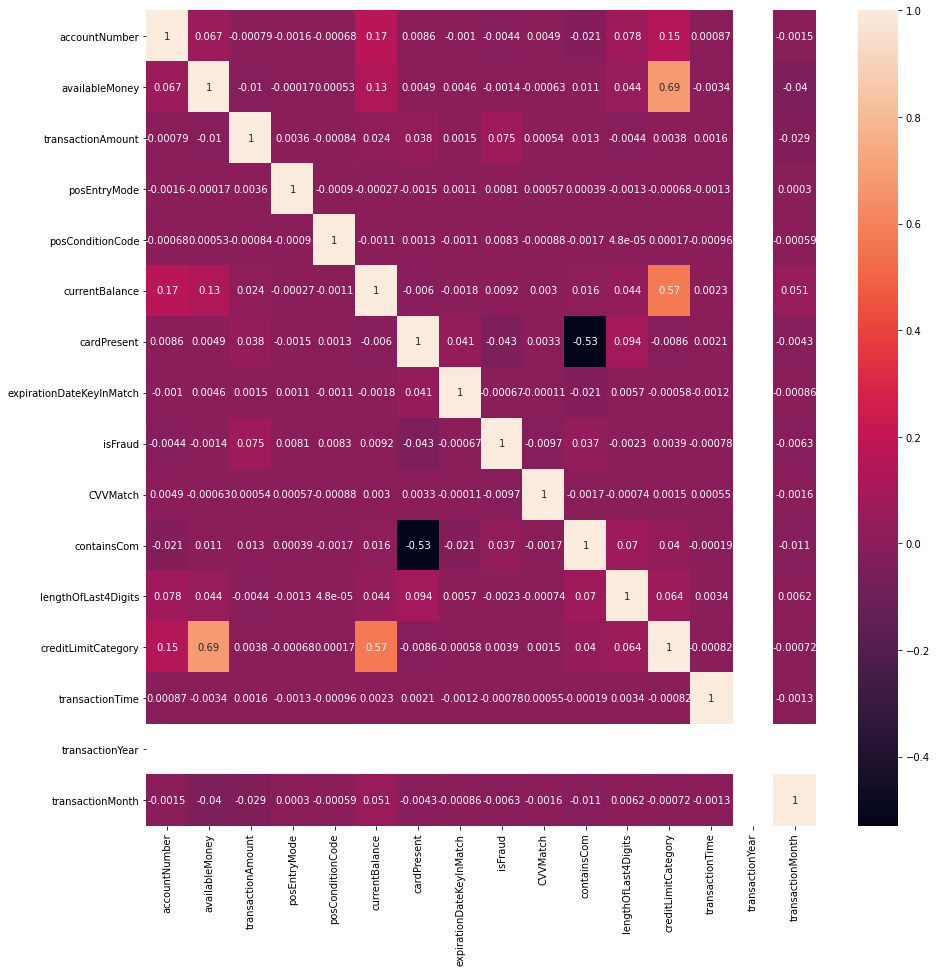

In [27]:
corrMatrix = card_data.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix,annot = True)
plt.show()

Observation:
1. highest correlation for isFraud column is transaction amount and our new created column 'containsCom'
2. There is also strong negative correlation between isFraud and cardPresent. This could signify that there are more fraud when transactions that are made online, thus card is not present.


## 5. Step 3: Assessing interactions between variables<a id='5._Interaction_between_variables'></a>

 ### 5.1 Bivariate visualizations for all combinations<a id='5.1_Bivariate_for_all'></a>
Question 7: Can I just use pairplot ?

Question 8: Why Do I need to know all interactions between variables. Why not just realtionship with targets

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5

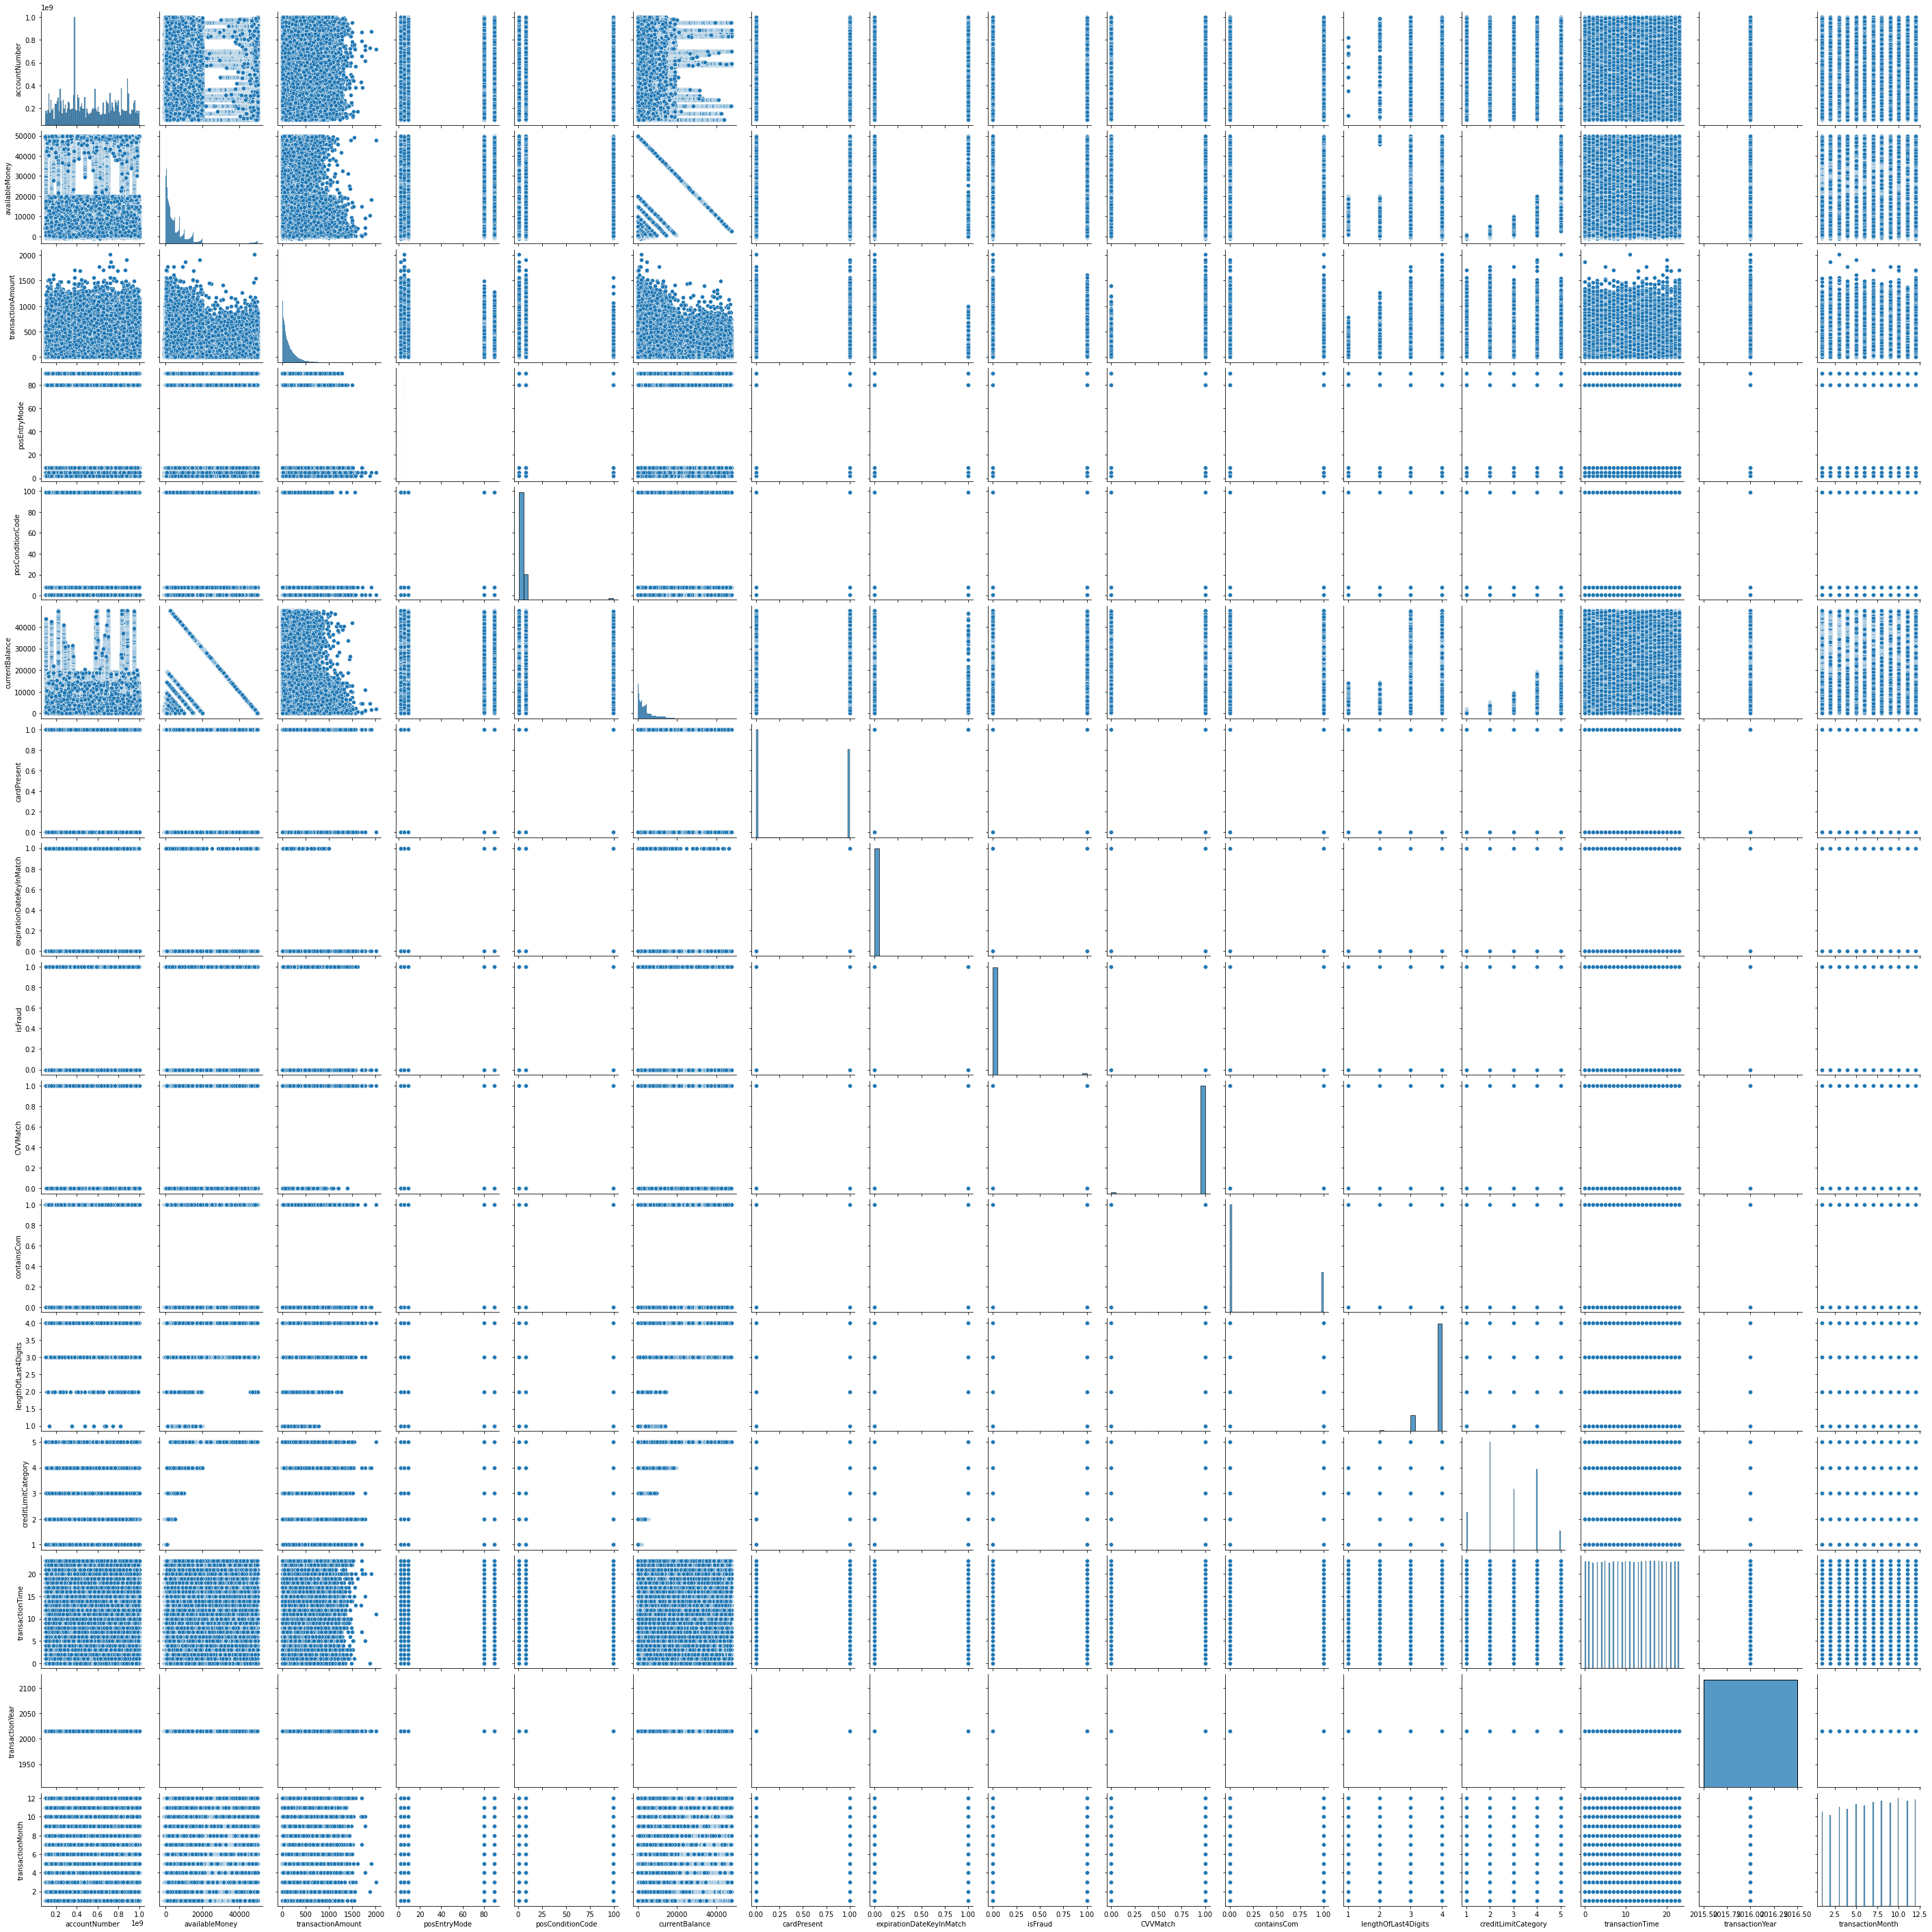

In [28]:
sns.pairplot(data=card_data)
plt.show()

 ### 5.2 Correlation matrices<a id='5.2_Correlation_matrices'></a>
 Observation:
 1. There is the obvious high correlation between credit card limit and current balance and available money
 2. However there is also correlation between account number and current balance. What is the relationship here ?

#### account number and current balance relationship

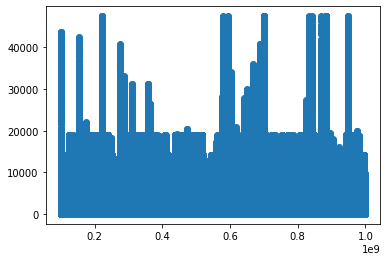

In [29]:
# there are many account number. lets do scatter plot first
plt.scatter(card_data['accountNumber'],card_data['currentBalance'])
plt.show()

Question 9: Is there another way to look at this relationship?

 ### 5.3 summary statistics of variable x for different categories of y<a id='5.3_Compare_summary_statistic'></a>
 Question 10: How do I do this ?

## 6. Step 7: Exploring data across many dimensions<a id='6._Explore_Data'></a>

### 6.1. Hypothesis Testing<a id='6.1_Hypothesis_test'></a>

null hypothesis: there is no difference between mean in transaction amount of fraud and non fraud transactions
Alternative hypothesis: there is a differrence between the mean

Question 11: Do I do Permutation test ? or basic T test ?

### 6.2. Questions<a id='6.2_Questions'></a>

Question 12: Is there anything else that I should be looking at before moving on to data modelling?